In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "0"
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torchvision.utils as vutils
from torch.autograd import Variable
import torchvision.models as models
import torchvision.transforms.functional as TF
import pathlib

from PIL import Image
from IPython.display import display

from losses import *
from dataloader import *
from util import *
import random
import math


In [5]:
from model import Inpaint_generator, Tumor_shape, Tumor_grade

tumor_shape = Tumor_shape().cuda()
tumor_grade = Tumor_grade().cuda()
inp_gen = Inpaint_generator().cuda()

In [7]:
tumor_shape.load_state_dict(torch.load('./MODEL/' + 'tumor_shape.pth'))
tumor_grade.load_state_dict(torch.load('./MODEL/' + 'tumor_grade.pth'))
inp_gen.load_state_dict(torch.load('./MODEL/' + 'inp_gen.pth'))

print('model uploaded')


<All keys matched successfully>

In [11]:
# test_image_list
F_test_img_list = glob.glob('./temp_slice/F/*.png')
T1_test_img_list = glob.glob('./temp_slice/T1/*.png')
T1c_test_img_list = glob.glob('./temp_slice/T1c/*.png')
T2_test_img_list = glob.glob('./temp_slice/T2/*.png')

print("len:", len(F_test_img_list), len(T1_test_img_list), len(T1c_test_img_list), len(T2_test_img_list))

len: 33 33 33 33


shape: (256, 256) 
 range of img: 0 ~ 223


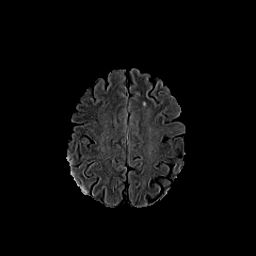

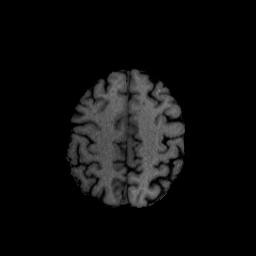

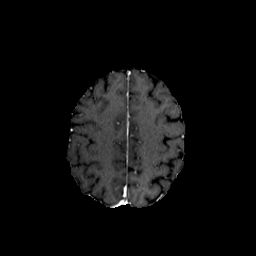

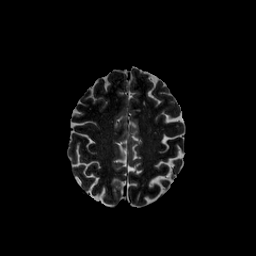

In [46]:
# load one image

temp_idx = 30 # it can be modified
temp_F = cv2.imread(F_test_img_list[temp_idx], 0) 
temp_T1 = cv2.imread(T1_test_img_list[temp_idx], 0)
temp_T1c = cv2.imread(T1c_test_img_list[temp_idx], 0)
temp_T2 = cv2.imread(T2_test_img_list[temp_idx], 0)
print('shape:', temp_F.shape, '\n', 'range of img:', temp_F.min(), '~', temp_F.max())

display(Image.fromarray(temp_F))
display(Image.fromarray(temp_T1))
display(Image.fromarray(temp_T1c))
display(Image.fromarray(temp_T2))

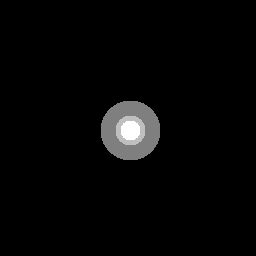

In [31]:
# Set level circle
temp_circle = make_level_circle(x_center = 130,y_center = 130, radius_1 = 10, radius_2 = 15,radius_3 = 30)
display(Image.fromarray(temp_circle[0][0].numpy()*255).convert('RGB'))

In [52]:
temp_circle.shape

torch.Size([1, 1, 256, 256])

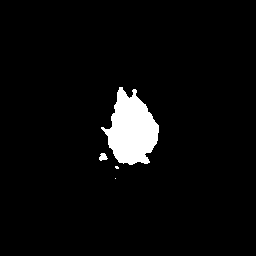

In [51]:
# Make a Binary Mask
with torch.no_grad():
    binary_circle = unify(temp_circle).reshape(1,1,256,256)
    binary_circle_torch = binary_circle.cuda()
    uni_B = unify(temp_F).reshape(1,1,256,256)
    uni_B_torch = uni_B.cuda()
    
    binary_mask = unify(tumor_shape(torch.cat([uni_B_torch, binary_circle_torch], 1)).detach().cpu().numpy())
    binary_mask_torch = binary_mask.cuda()

    display(Image.fromarray(binary_mask[0][0].numpy()*255).convert('RGB'))



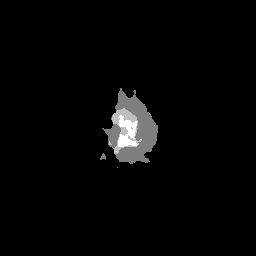

In [73]:
# Make a Grade Mask
with torch.no_grad():
    temp_circle_torch = temp_circle.float().cuda()
    grade_mask = quantize(tumor_grade(torch.cat([binary_mask_torch, temp_circle_torch], 1)).detach().cpu().numpy())
    grade_mask_torch = grade_mask.cuda()
    
    display(Image.fromarray(grade_mask[0][0].numpy()*255).convert('RGB'))

results without merging


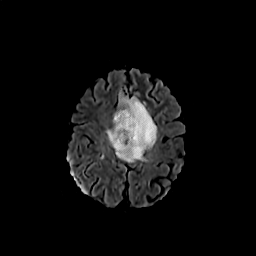

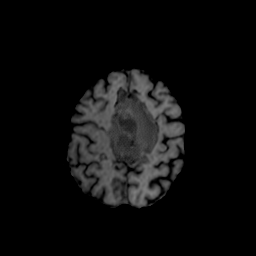

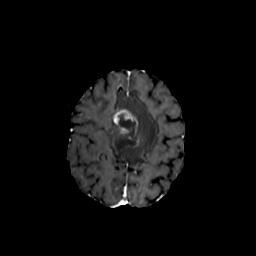

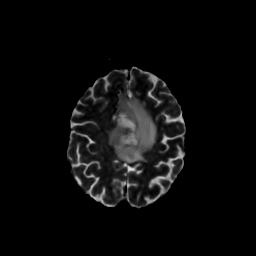

results with merging


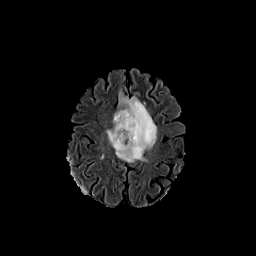

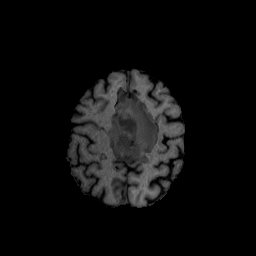

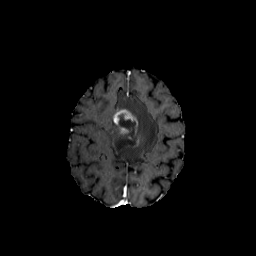

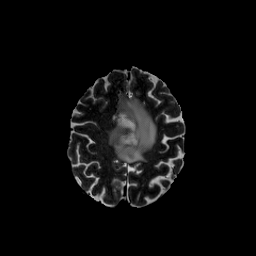

In [82]:
# inpaint
transforms_ = transforms.Compose([
            transforms.ToPILImage(),
            transforms.ToTensor()])

with torch.no_grad():
    temp_F_torch = transforms_(temp_F).reshape(1,1,256,256)
    temp_T1_torch = transforms_(temp_T1).reshape(1,1,256,256)
    temp_T1c_torch = transforms_(temp_T1c).reshape(1,1,256,256)
    temp_T2_torch = transforms_(temp_T2).reshape(1,1,256,256)
    
    brain_torch = torch.cat((temp_F_torch, temp_T1_torch, temp_T1c_torch, temp_T2_torch), 1).cuda()
    brain_blank_torch = (brain_torch * (1-binary_mask_torch))

    out_brain_torch = inp_gen(brain_blank_torch, grade_mask_torch)
    F_, T1_, T1c_, T2_ = torch.split(out_brain_torch.detach().cpu(),split_size_or_sections=1, dim=1)
    
    print('results without merging')
    display(Image.fromarray(F_[0][0].numpy()*255).convert('RGB'))
    display(Image.fromarray(T1_[0][0].numpy()*255).convert('RGB'))
    display(Image.fromarray(T1c_[0][0].numpy()*255).convert('RGB'))
    display(Image.fromarray(T2_[0][0].numpy()*255).convert('RGB'))

    # merge with noraml brain (at non-tumor parts)
    print('results with merging')
    out_brain_final = out_brain_torch * binary_mask_torch + brain_torch * (1-binary_mask_torch)
    F_final, T1_final, T1c_final, T2_final = torch.split(out_brain_final.detach().cpu(),split_size_or_sections=1, dim=1)

    display(Image.fromarray(F_final[0][0].numpy()*255).convert('RGB'))
    display(Image.fromarray(T1_final[0][0].numpy()*255).convert('RGB'))
    display(Image.fromarray(T1c_final[0][0].numpy()*255).convert('RGB'))
    display(Image.fromarray(T2_final[0][0].numpy()*255).convert('RGB'))
  